# Explore here

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

In [67]:
print(f"numpy version: {np.__version__}")

numpy version: 2.0.0


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv')
df.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


## Lectura del conjunto de datos

In [3]:
df.dtypes

date      object
sales    float64
dtype: object

In [4]:
df.date = pd.to_datetime(df.date)
df.date = df.date.dt.date
df.head()

,date,sales
0,2022-09-03,55.292157
1,2022-09-04,53.803211
2,2022-09-05,58.141693
3,2022-09-06,64.530899
4,2022-09-07,66.013633


In [5]:
df.date = pd.to_datetime(df.date)
df.dtypes

date     datetime64[ns]
sales           float64
dtype: object

In [6]:
df.set_index('date', inplace=True)

In [7]:
df.shape

(366, 1)

In [8]:
df.isna().sum()

sales    0
dtype: int64

In [9]:
df.nunique()

sales    366
dtype: int64

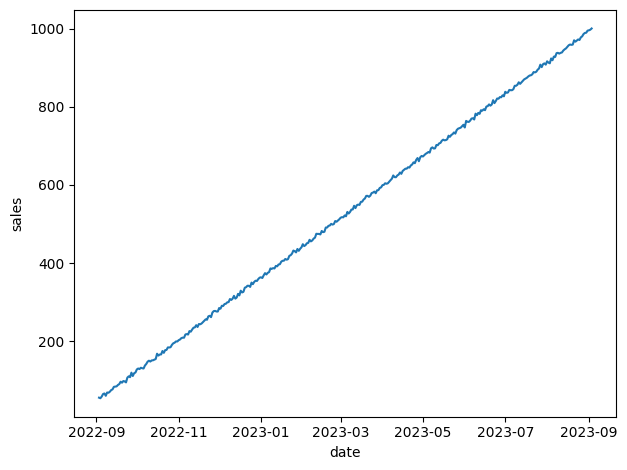

In [10]:
series = df.sales
fig, axis = plt.subplots()

sns.lineplot(series)

plt.tight_layout()

plt.show()

## Análisis de una serie temporal

Paso 2: Construye y analiza la serie temporal
Construye la estructura de datos válida para la serie temporal, grafícala y, a continuación, analízala y responde a las siguientes preguntas:

1. ¿Cuál es el tensor de la serie temporal?
2. ¿Cuál es la tendencia?
3. ¿Es estacionaria?
4. ¿Existe variabilidad o presencia de ruido?

1. El tensor de esta serie temporal en el dataset base es segundos pero por temas de simplicidad he decidido eliminar hora, minutos y segundos, por lo tanto el tensor de esta serie temporal sería la fecha el día en formato DD-MM-YYYY.

In [42]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(series, period = 12)
decomposition

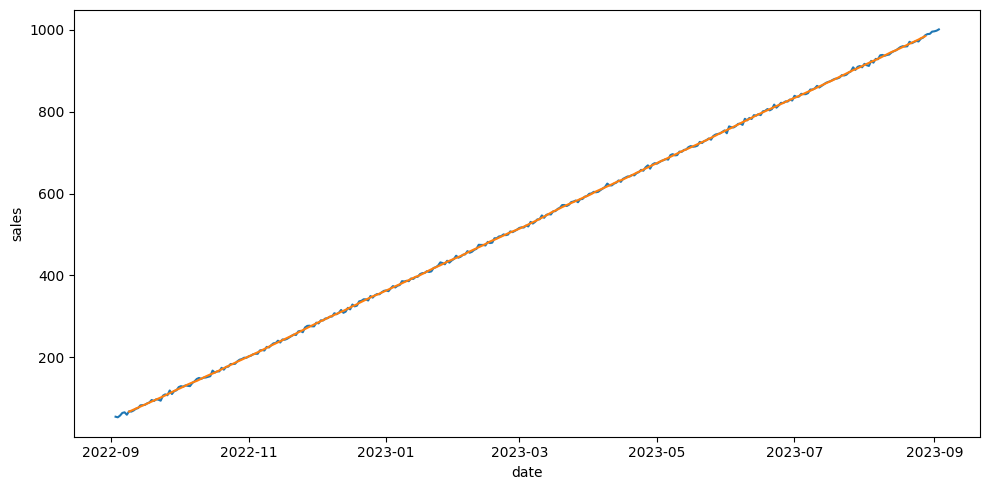

In [12]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = series)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

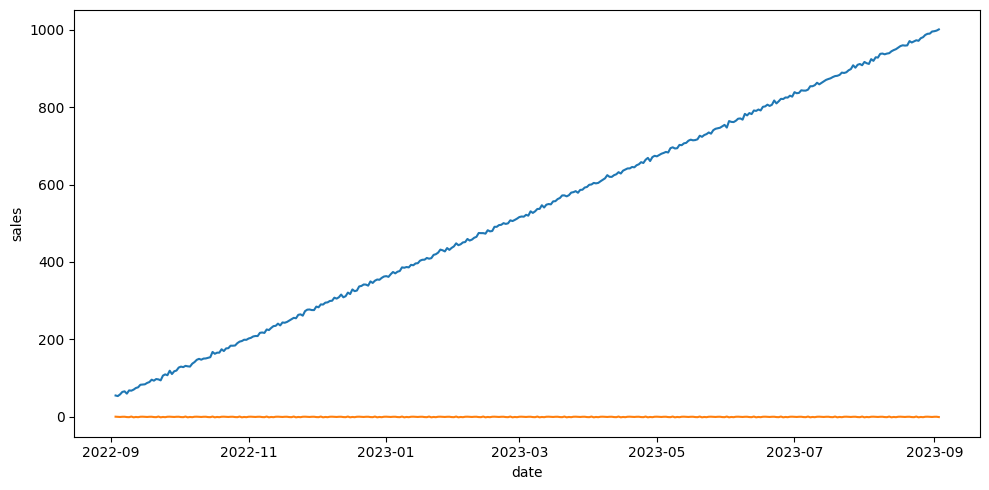

In [13]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = series)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

A simple vista se puede observar que la serie es no estacional. Pero voy aplicar la prueba ADF para verificar que efectivamente la serie es no estacional.

In [14]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(series)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

El resultado de la prueba ADF (Augmented Dickey-Fuller) sugiere que la serie no es estacionaria. Por lo tanto el modelo podría realizar predicciones inexactas. Para intentar corregir esta serie no estacional voy aplicar la diferenciación para convertir la serie no estacionaria en una serie estacionaria al eliminar las tendencias de largo plazo. Además el modelo ARIMA supone que los datos son estacionarios para poder hacer predicciones precisas.

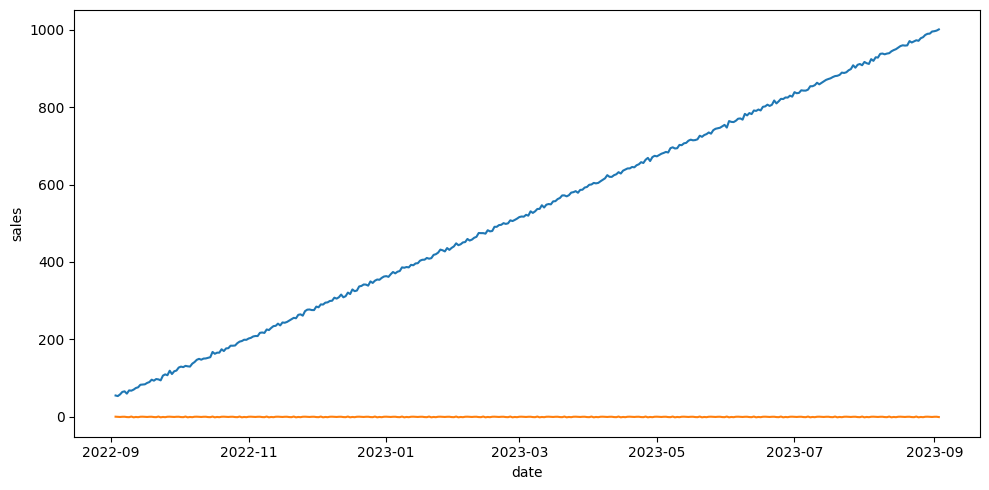

In [15]:
residual = decomposition.resid
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = series)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

## Diferenciar la serie

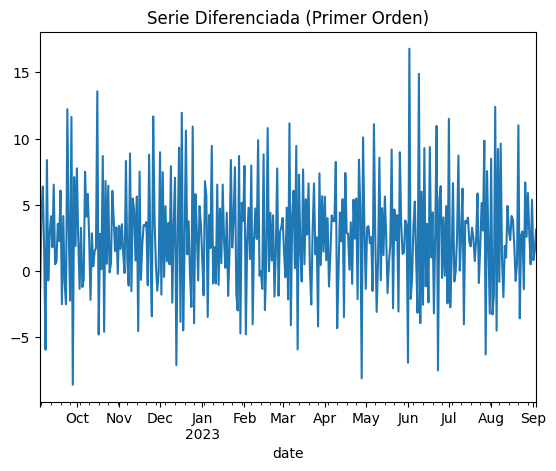

In [16]:
# Aplicar diferenciación de primer orden
df['differenced'] = df['sales'].diff()
df['differenced'].dropna().plot(title="Serie Diferenciada (Primer Orden)")
plt.show()

Ahora hemos conseguido eliminar la tendencia alcista que la serie base tenia, y podemos trabajar mejor con nuestro modelo para intentar identificar patrones.

In [24]:
serie_diff = df.differenced

In [28]:
serie_diff.dropna(inplace=True)

In [29]:
test_stationarity(serie_diff)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

In [41]:
decomposition_2 = seasonal_decompose(serie_diff, period = 12)

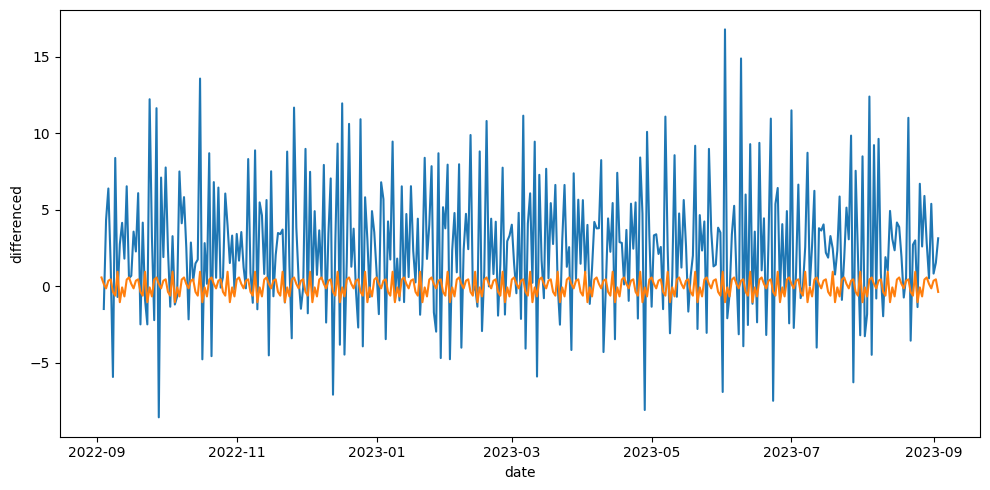

In [30]:
seasonal = decomposition_2.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = serie_diff)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

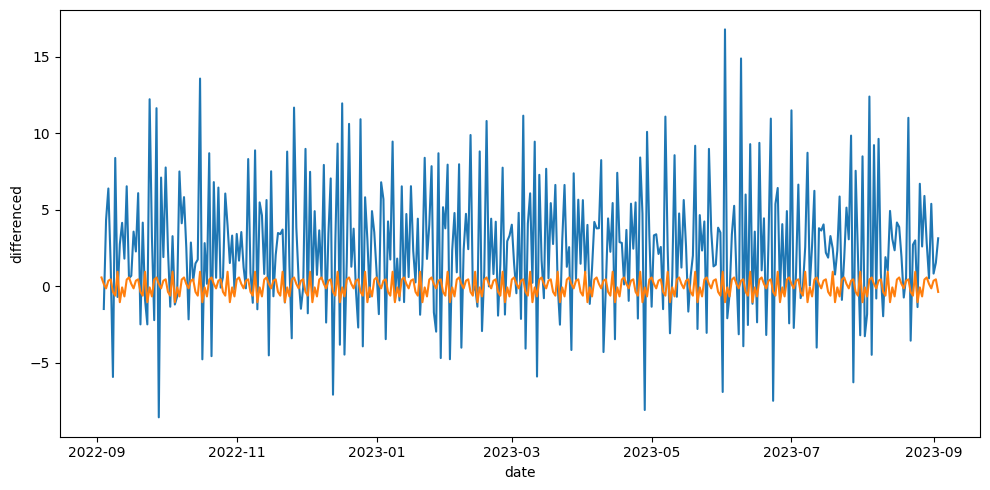

In [43]:
residual_2 = decomposition_2.resid
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = serie_diff)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

## Análisis de la autocorrelación

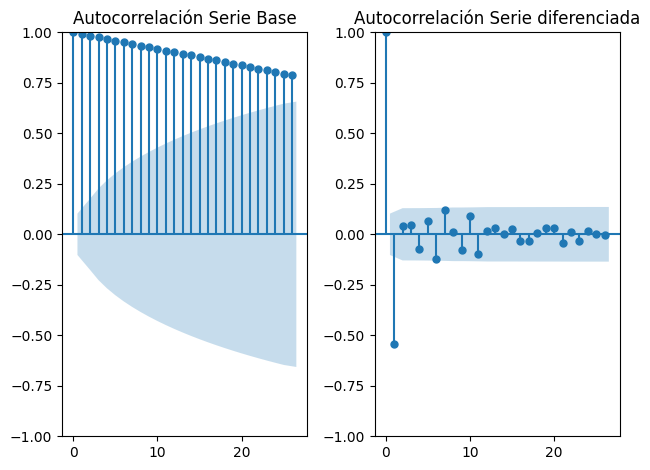

In [39]:
fig, ax = plt.subplots(1,2)
plot_acf(series, ax = ax[0], title='Autocorrelación Serie Base')
plot_acf(serie_diff, ax= ax[1], title='Autocorrelación Serie diferenciada')

plt.tight_layout()

plt.show()

Resumen visual del gráfico de autocorrelación:
1. En la primera gráfica (serie Base) se observa una autocorrelación alta y positiva que disminuye gradualmente, eso indica la presencia de una tendencia en los datos. Esto significa que los valores anteriores tienen una fuerte influencia en los valores actuales, lo que es común en series no estacionarias.
2. En cambio en la segunda gráfica (serie diferenciada) se observa una fuerte autocorrelación en los primeros lags, por lo tanto la serie no tiene dependencia temporal significativa y esto sugiere que la serie podría ser ruido blanco. También se puede observar que existe una autocorrelación alta en rezagos cercanos (lags 1-2), suele indicar una fuerte relación entre valores cercanos en el tiempo, sugiriendo que la serie tiene tendencia o estacionalidad.

Verifico la autocorrelación de los residuos

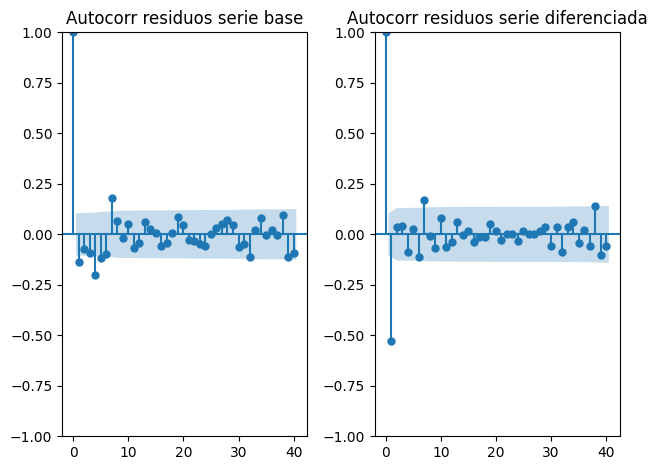

In [46]:
# Graficar la autocorrelación de los residuos
fig, ax = plt.subplots(1,2)

plot_acf(residual.dropna(), lags=40, ax=ax[0], title= 'Autocorr residuos serie base')
plot_acf(residual_2.dropna(), lags=40, ax=ax[1], title= 'Autocorr residuos serie diferenciada')

plt.tight_layout()
plt.show()

Viendo gráficamente la autocorrelación de los residuos podemos concluirestas dos cosas:
1. Alta correlación en los primeros lags: Indica que el modelo no ha capturado completamente la dependencia a corto plazo. Es decir, el modelo tiene dificultades para explicar la relación inmediata entre los puntos temporales cercanos.
2. Correlación cercana a 0 en los lags posteriores: Indica que, en general, los residuos a largo plazo no tienen correlación, lo cual es positivo ya que el modelo no tiene patrones no explicados, y los errores se distribuyen de manera aleatoria en el tiempo.

## Entrenamiento del modelo

Seleccionar los parámetros del modelo ARIMA
Voy a seleccionar el valor de "p" y "q", basandóme en el primer lag de la PACF que cruza el límite de confianza nos da una indicación de "p" y q (MA), determinado por el gráfico ACF, donde primer lag en el que la ACF cruza el límite de confianza nos da una indicación de "q".

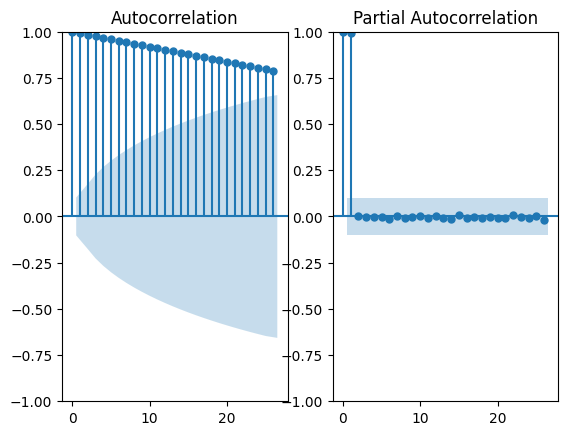

In [71]:
_, ax = plt.subplots(1,2)

plot_acf(series, ax=ax[0])
plot_pacf(series, ax=ax[1])
plt.show()

Los valores que voy a escoger van a ser 1, 1 ,1 ya qué como vemos en los gráficos, tanto para los dos, el primer lag cruza el límite de confianza. Y el valor de "d", también va ser igual a 1, ya qué cómo hemos visto nuestra serie no era estacionaria y eso nos podría conllevar problemas a la hora de predecir.

In [73]:
# Definir el modelo ARIMA
model = ARIMA(df['sales'], order=(1, 1, 1))

# Ajustar el modelo
model_fit = model.fit()

# Resumen del modelo
print(model_fit.summary())

C:\Users\macar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\macar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\macar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  366
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1049.226
Date:                Wed, 18 Sep 2024   AIC                           2104.453
Time:                        18:21:18   BIC                           2116.153
Sample:                    09-03-2022   HQIC                          2109.103
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000      0.000   2045.173      0.000       0.999       1.001
ma.L1         -0.9996      0.436     -2.291      0.022      -1.855      -0.144
sigma2        18.1320      8.063      2.249      0.0

Interpretación del summary

1. Hay una relación postiva entre el valor anterior y el sigueinte.
2. El modelo corrige los errores pasados, ya que ma.L1 es negativo

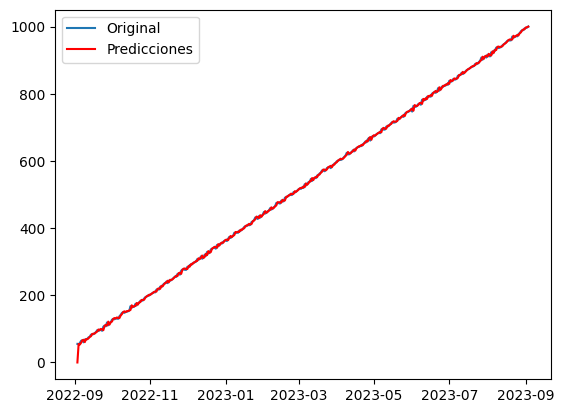

In [74]:
# Predicción dentro de la muestra
pred = model_fit.fittedvalues

# Graficar la serie original y las predicciones
plt.plot(df['sales'], label='Original')
plt.plot(pred, color='red', label='Predicciones')
plt.legend()
plt.show()

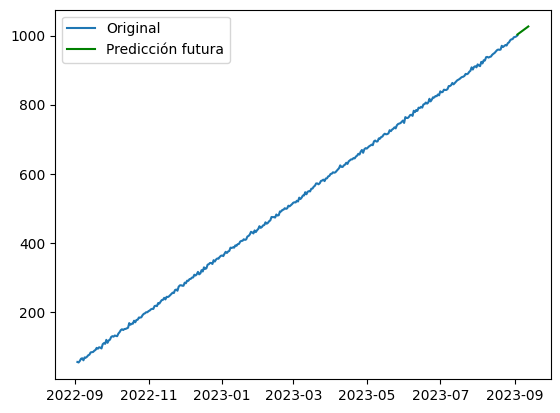

In [75]:
# Predicciones hacia el futuro
forecast = model_fit.forecast(steps=10)  # Predecir los próximos 10 periodos

# Visualizar las predicciones
plt.plot(df['sales'], label='Original')
plt.plot(pd.date_range(df.index[-1], periods=10, freq='D'), forecast, color='green', label='Predicción futura')
plt.legend()
plt.show()

De los resultados predichos podemos observar que la tendencia de las ventas son alcistas.